In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']

import numpy as np
import healpy as hp
from bayestar import plot
import scipy
from scipy import special as ss
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import math
import NX01_bayesutils as bu
import NX01_utils as utils

## Injected map

In [12]:
clm_inj = np.load('nanogravTests_pointAnis.npy')

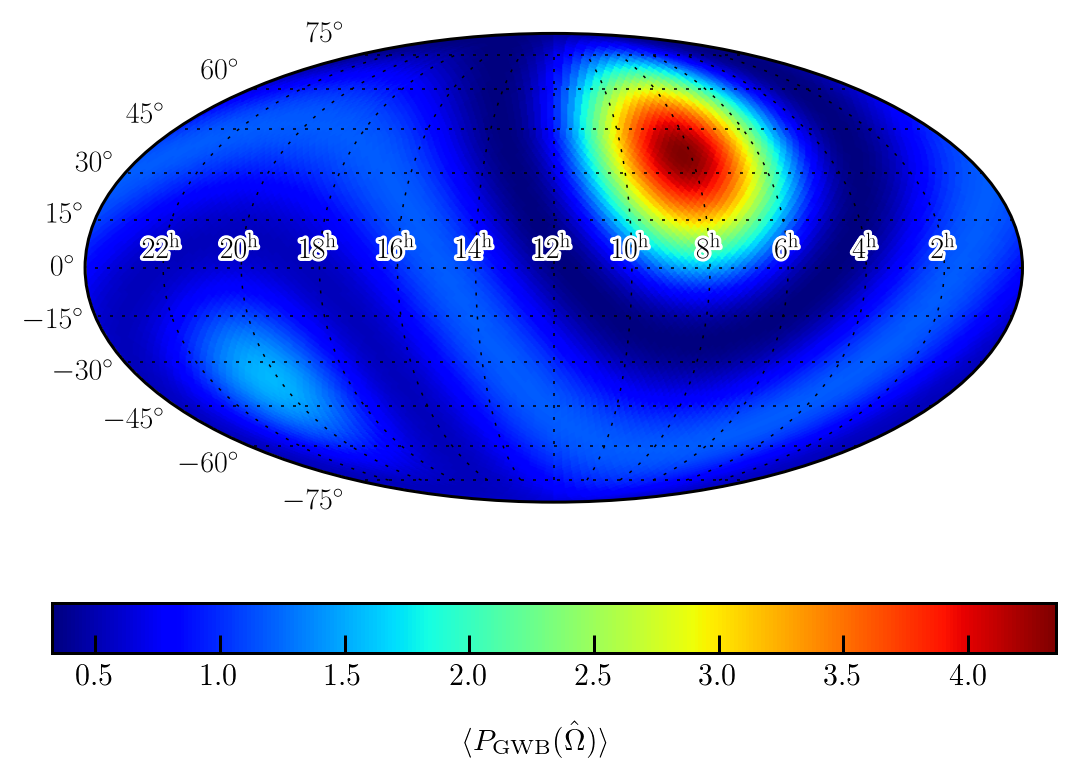

In [15]:
map_inj = bu.makeSkyMap(clm_inj[1:],lmax=4,nside=32)

## Spherical harmonic analysis: produce posterior averaged skymap

In [2]:
clm_chain = np.loadtxt('chains_mdc1_anisSim_hotspot/nanograv_gwbdetect_Lmax4_gamVary_reddetectpowerlaw_nmodes15/chain_1.0.txt')

In [3]:
print clm_chain.shape
print clm_chain[:,-3-(4+1)**2:-4].shape

(22500, 102)
(22500, 24)


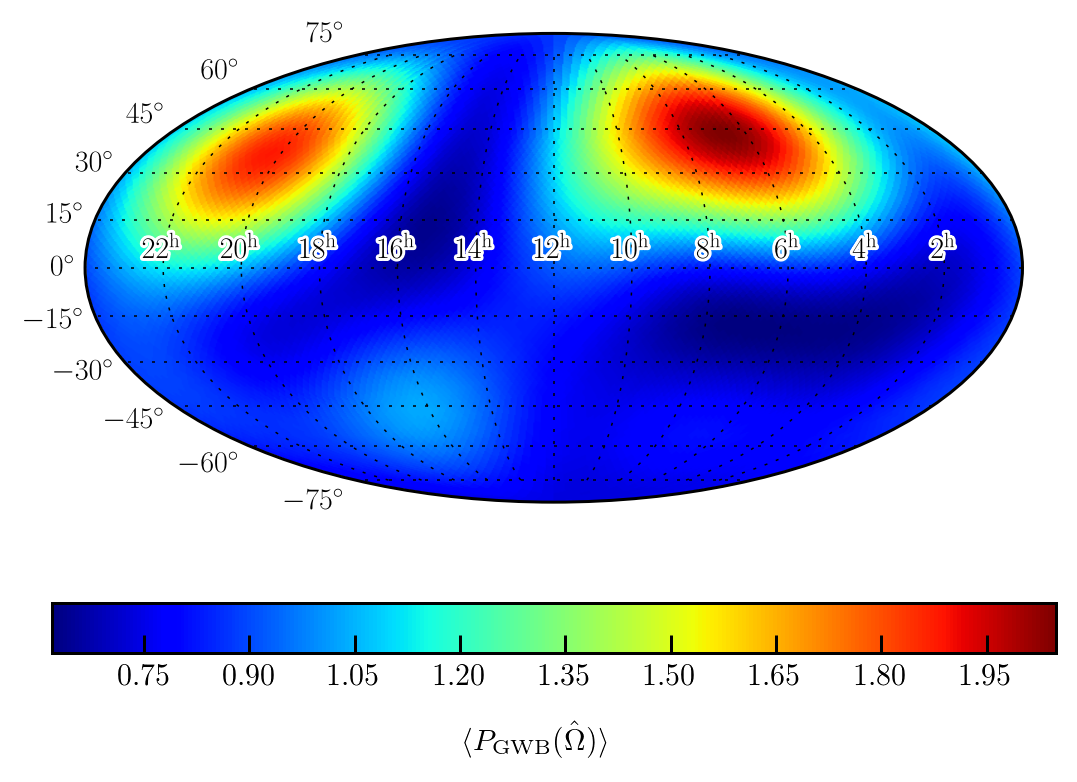

In [4]:
map_expected = bu.makeSkyMap(clm_chain[:,-3-(4+1)**2:-4],lmax=4,nside=32)

## Point-source anisotropy: produce posterior averaged skymap

In [5]:
pointSrc_chain = np.loadtxt('chains_mdc1_anisSim_hotspot/nanograv_gwbdetect_pointSrc_gamVary_reddetectpowerlaw_nmodes15/chain_1.0.txt')

Sigma is 68.754935 arcmin (0.020000 rad) 
-> fwhm is 161.905500 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


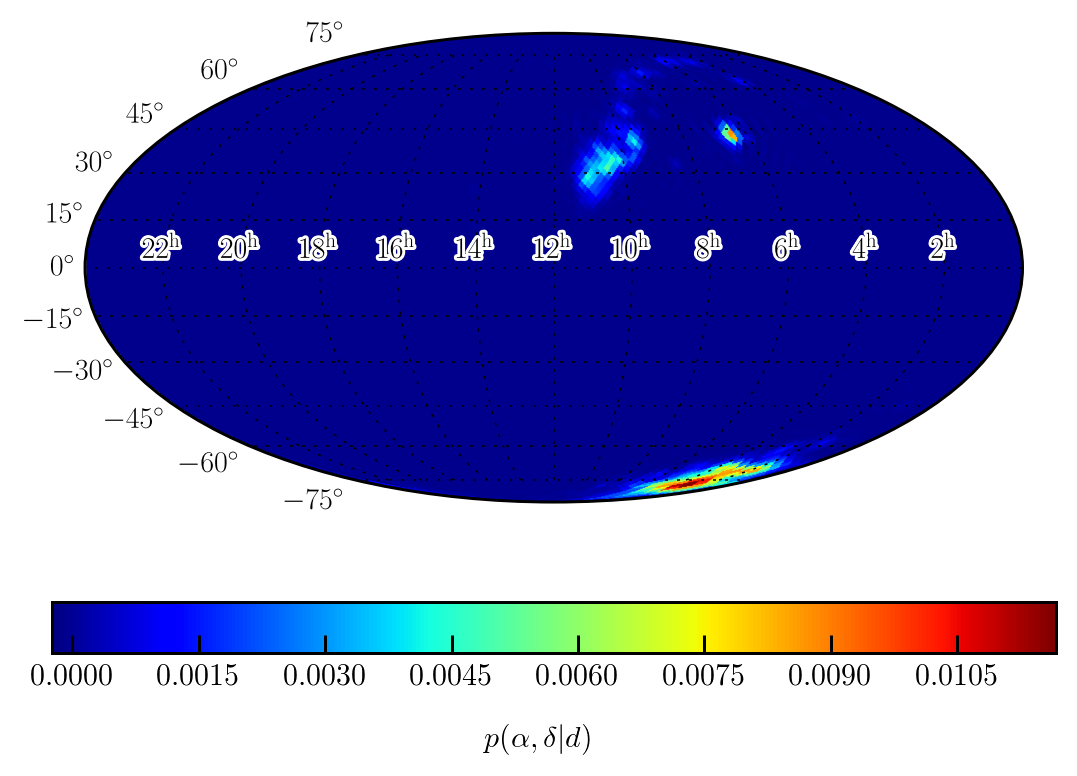

In [11]:
#map_point = bu.plotSkyMap(pointSrc_chain[:,74], np.pi/2. - np.arccos(pointSrc_chain[:,75]), nside=64, cmap='jet', outfile='skymap.pdf')
map_point = bu.plotSkyMap(pointSrc_chain[:,74] + np.pi, np.pi/2. - (np.pi - np.arccos(pointSrc_chain[:,75])), nside=32, cmap='jet', outfile='skymap.pdf')